In [4]:
import os
import json
import pandas as pd
os.chdir("..")
%pwd

'/home/jupyter/crisp'

In [5]:
from main import run
from utils.gcp_helpers import get_dataframe_from_bucket

In [6]:
# create train data
# data = get_dataframe_from_bucket("Radiation/mouse/combined/mouse.combined.expression.071121.tsv","ah21_data", "ah21_data", sep="\t")
# data = data.T
# data.columns = data.iloc[0]
# data = data.iloc[1:]
# data = data.astype(float)
# metadata = get_dataframe_from_bucket("Radiation/mouse/combined/mouse.metadata.combined.071121.csv","ah21_data", "ah21_data", sep=",")
# merged_data = pd.merge(metadata, data, left_on="sample", right_index=True)
# merged_data = merged_data[merged_data.dataset == "GSE124612"]
# merged_data.to_pickle(dataset_file)

In [7]:
dataset_file = "data/mouse_crisp_input.pkl"
verbose = 1
output_data_regime = 'real-valued'

In [8]:
merged_data_columns = pd.read_pickle('data/mouse_crisp_input.pkl').columns

In [9]:
merged_data_values = pd.read_pickle('data/mouse_crisp_input.pkl')[merged_data_columns[9:]]#.astype(float) 

In [26]:
variances = merged_data_values.std()

In [29]:
0.05*0.05

0.0025000000000000005

In [35]:
len(variances) - len(variances[variances < 0.25])

1363

In [21]:
len(variances)

16353

In [25]:
13979 + 1523

15502

<AxesSubplot:>

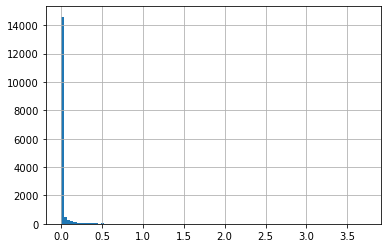

In [12]:
variances.hist(bins=100)

In [33]:
# define config
config = {
    "name": "Example Experiment for AH casual ensemble",
    "short_name": "ah_experiment_notebook",
    "bucket_project": "fdl-us-astronaut-health",
    "bucket_name": "ah_21_data",
    "bucket_path": "gs://ah_21_data",
    "verbose": verbose,
    "test_val_split": [0.1, 0.1],
    "per_variant_experiment": False,
    "data_options": {
        #'dataset_fp': '../data/test_multiclass.pkl',
        'synthetic_train_test_split' : True,
        #'dataset_fp' : outfile,
        #'dataset_fp_train' : outfile_train,
       # 'dataset_fp_test' : outfile_test,
        'dataset_fp' : dataset_file,
        'output_data_regime' : output_data_regime,
        'subject_keys': 'sample',
        'targets': ['dose_Gy'],
        #'predictors': ['All'],
        'predictors': list(merged_data_columns[9:]),
        'environments': ['timepoint_hr'],
        'exclude': ['organism', 'gender', 'strain', 'irradiated', 'radiation']
    },
    "feature_selection_options": {
        "max_features": 20,
        "verbose": verbose,
        "seed": 12,
        "variance_threshold": 0.25
    },
    "ensemble_options": {
        "models": ["LIRM"], # ["ICP", "DCF", "LIRM", "NLICP"],
        "LIRM" : {
            "use_icp_initialization": False,
            "verbose": verbose,
            "n_iterations": 1000,
            "seed": 0,
            "lr": 0.001,
            "cuda": False,
            "output_data_regime" : output_data_regime,
        },
        "DCF" : {
            "minP": 0.1,
            "maxP": 0.9,
            "minFeatures": 1,
            "minAccuracy": 0.5,
            "seed": 0,
            "verbose": verbose,
            "target": ["Target"],
            "output_pvals": False,
            "output_data_regime" : output_data_regime,
        },
        "NLICP" : {
            "max_set_size": 2,
            "alpha": 0.05,
            "seed": 12,
            "verbose": verbose,
            "method": "MLP",
            "hidden_dim": 256,
            "output_data_regime" : output_data_regime,
        },
        "LICP" : {
            "max_set_size": 2,
            "alpha": 0.05,
            "seed": 12,
            "verbose": verbose,
            "output_data_regime" : output_data_regime,
        },
    },
     "use_cloud":False,
    "results_directory": "results/"
}

In [34]:
# Reinitialise datasets without zero variance columns
from dataio.datasets import get_datasets_for_experiment
environment_datasets, val_dataset, test_dataset = get_datasets_for_experiment(config)

######################### LIST CHOSEN ENSEMBLE METHODS #############################
ensemble_options = config.get('ensemble_options', {})
data_config = config.get('data_options', {})
selection_config = config.get('feature_selection_options', {})
# Load list of models to include in ensemble, if not specified, run them all
selected_models = ensemble_options.get("models", ["ERM", "RF", "ICP", "IRM", "DCF", "LIRM", "NLICP"])
print("Running Ensemble with the following models: ", selected_models)
# Initialise empty list to store per method results to outputs to file system/ cloud storage
to_bucket_results = []

############################# FEATURE REDUCTION 1 ######################################
# 1. Remove any zero variance features
# - Save list to results directory
from utils.ZeroVarianceChecker import ZeroVarianceChecker
print('Checking for features with zero variance')
# Flag for checking zero variance across all environments ([train_environments], val, test) or within any one environment
var_args = {
    'in_each_env': selection_config.get('zero_variance_in_each_env', False),
    'variance_threshold': selection_config.get('variance_threshold',0)
}
zero_var_checker = ZeroVarianceChecker(environment_datasets, val_dataset, test_dataset, var_args)
if var_args['in_each_env']:
    zero_var_columns = zero_var_checker.zero_var_cols
    if config['verbose']:
        print('In atleast one environment the following columns had zero variance:', zero_var_columns)
    save_dict_to_json({'zero std columns removed': zero_var_columns},
                      config['results_directory'] + 'zero_std_columns.json')
else:
    zero_var_columns = zero_var_checker.zero_var_cols
    if config['verbose']:
        print('Across all environments the following columns had zero variance:', zero_var_columns)
keep_columns = zero_var_checker.reduced_feature_list()

selected_feature_list = keep_columns
config['data_options']['predictors'] = selected_feature_list
# Reinitialise datasets without zero variance columns
environment_datasets, val_dataset, test_dataset = get_datasets_for_experiment(config)


Running a per sample experiment
Loaded  5  train environments
Env  0  has  42  samples
X shape  (42, 16353)  y shape  (42, 1)
Env  1  has  41  samples
X shape  (41, 16353)  y shape  (41, 1)
Env  2  has  37  samples
X shape  (37, 16353)  y shape  (37, 1)
Env  3  has  40  samples
X shape  (40, 16353)  y shape  (40, 1)
Env  4  has  42  samples
X shape  (42, 16353)  y shape  (42, 1)
Loaded val set, X shape: (22, 16353)  y shape:  (22, 1)
Loaded test set, X shape: (24, 16353)  y shape:  (24, 1)
Running Ensemble with the following models:  ['LIRM']
Checking for features with zero variance
variance threshold is 0.25
Across all environments the following columns had zero variance: ['0610005C13Rik', '0610007C21Rik', '0610007L01Rik', '0610007P08Rik', '0610007P14Rik', '0610007P22Rik', '0610008F07Rik', '0610009B22Rik', '0610009D07Rik', '0610009K14Rik', '0610009O20Rik', '0610010F05Rik', '0610010K14Rik', '0610010O12Rik', '0610011L14Rik', '0610012G03Rik', '0610012H03Rik', '0610030E20Rik', '0610031J06

In [36]:
corr = Correlation(environment_datasets, val_dataset, test_dataset, corr_args)

NameError: name 'Correlation' is not defined

In [12]:
corr_results_dict = corr.predictor_results()

In [13]:
keep_columns = corr_results_dict["results"]['retained_columns']
column_pairs_df = corr_results_dict["results"]['invariant_correlations']

selected_feature_list = keep_columns
original_dimensionality = len(selected_feature_list)
config['data_options']['predictors'] = selected_feature_list
# Reinitialise datasets without highly correlated feature pairs
environment_datasets, val_dataset, test_dataset = get_datasets_for_experiment(config)

Running a per sample experiment
Loaded  5  train environments
Env  0  has  40  samples
X shape  (40, 30)  y shape  (40, 1)
Env  1  has  37  samples
X shape  (37, 30)  y shape  (37, 1)
Env  2  has  45  samples
X shape  (45, 30)  y shape  (45, 1)
Env  3  has  41  samples
X shape  (41, 30)  y shape  (41, 1)
Env  4  has  39  samples
X shape  (39, 30)  y shape  (39, 1)
Loaded val set, X shape: (22, 30)  y shape:  (22, 1)
Loaded test set, X shape: (24, 30)  y shape:  (24, 1)


In [ ]:
run(config)

Running a per sample experiment
Loaded  5  train environments
Env  0  has  42  samples
X shape  (42, 16353)  y shape  (42, 1)
Env  1  has  42  samples
X shape  (42, 16353)  y shape  (42, 1)
Env  2  has  43  samples
X shape  (43, 16353)  y shape  (43, 1)
Env  3  has  44  samples
X shape  (44, 16353)  y shape  (44, 1)
Env  4  has  43  samples
X shape  (43, 16353)  y shape  (43, 1)
Loaded val set, X shape: (11, 16353)  y shape:  (11, 1)
Loaded test set, X shape: (23, 16353)  y shape:  (23, 1)
Running Ensemble with the following models:  ['LIRM']


/home/jupyter/crisp/utils/CorrelationToTarget.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_x = np.array(all_x)
/home/jupyter/crisp/utils/CorrelationToTarget.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_y = np.array(all_y)


Checking for features with zero variance
Across all environments the following columns had zero variance: []
Running a per sample experiment
Loaded  5  train environments
Env  0  has  42  samples
X shape  (42, 16353)  y shape  (42, 1)
Env  1  has  42  samples
X shape  (42, 16353)  y shape  (42, 1)
Env  2  has  43  samples
X shape  (43, 16353)  y shape  (43, 1)
Env  3  has  44  samples
X shape  (44, 16353)  y shape  (44, 1)
Env  4  has  43  samples
X shape  (43, 16353)  y shape  (43, 1)
Loaded val set, X shape: (11, 16353)  y shape:  (11, 1)
Loaded test set, X shape: (23, 16353)  y shape:  (23, 1)
Running correlation analysis
